# Continuous Control Report

---

This report details the implimentation and learning algorithm of my [implementation](./Continuous_Control.ipynb) of an agent to solve the Unity ML Reacher environment using the 20 agents variant.  There is also single agent variant, but the code here is specifically implementated against the 20 agent environment.  Steps 1-3 are as provided in the starter notebook, with steps 4 and on detailing my journey to solve the environment.

As detailed in the [README](./README.md), the environment is considered solved, when the average (over 100 episodes) of those average scores is at least +30. 

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import random
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from itertools import accumulate
from operator import itemgetter

import env_utils

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="Reacher.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [9]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.12099999729543924


### 4. Choose a learning Algorithm

For [Project 1: Navigation](https://github.com/mleonardallen/nd893-p1-navigation), I leveraged the [DQN Algorithm](https://arxiv.org/abs/1312.5602).

> We present the first deep learning model to successfully learn control policies directly from high-dimensional sensory input using reinforcement learning. The model is a convolutional neural network, trained with a variant of Q-learning, whose input is raw pixels and whose output is a value function estimating future rewards. We apply our method to seven Atari 2600 games from the Arcade Learning Environment, with no adjustment of the architecture or learning algorithm. We find that it outperforms all previous approaches on six of the games and surpasses a human expert on three of them.

DQN is a value based approach, seeking the optimal `action-value` function.  Performing an action with value based approaches involves an `argmax` operation to find the action with the highest value.  However, the `Reacher` environment has a `continuous action space`, and value based approaches are not suited to continuous action spaces because of this argmax operation.

We could potentially discretize the action space, but I don't think this will be effective.  Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.  Even with a small amount of granularity in torque values produces a large number of possible actions.

| Torque Values | Actions |
| -- | -- |
| -1.0, -0.5, 0.0, 0.5, 1.0 | 625 |
| -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0 | 6,561 |

Because of the limitations of values based methods for continues action spaces, I think we need to use a policy based approach for the Reacher environment.  Policy based approaches seek to estimate the optimal policy directly, and therefore we don't run into this argmax issue that we have with value based approaches.

To begin, I'm going to keep it very simple using the [REINFORCE Algorithm](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.129.8871).  REINFORCE shows us how to adjust the parameters so that good actions are more probable and bad actions are less probable.  Likely, this algorithm will do poorly with this environment, but we can see the results and add improvements as we go. The REINFORCE algorithm is summarized below.

1. Use the policy $\pi_\theta$ to collect $m$ trajectories {$\tau^{(1)},\tau^{(2)},\dots,\tau^{(m)}$} with horizon $H$.  We refer to the $i$-th trajectory as 

    $\tau^{(i)} = (s^{(i)}_0, a^{(i)}_0,\dots,s^{(i)}_H, a^{(i)}_H,s^{(i)}_{H+1})$


2. Use the trajectories to estimate the gradient $\nabla_\theta U(\theta)$:

    $\nabla_\theta U(\theta) \approx \hat{g} := \frac1m\sum_{i=1}^m\sum_{t=0}^H\nabla_\theta log\pi_\theta(a_t^{(i)}|s_t^{(i)}R(\tau^{(i)})$


3. Update the weights of the policy:

    $\theta \leftarrow \theta + \alpha\hat{g}$


4. Loop over steps 1-3

### 5. Replace the Random Actions with Random Actions 🙃

<img align="right" alt="tanh" title="tanh" src="img/tanh.png" width="250"/>

Since this is my first project involving continuous actions spaces, I want to build the project step by step, until I have an agent that can efficiently learn and solve the environment.

First, I just want to replace the random actions produced by `np.random.randn` with a neural network that outputs random actions.  The actions are random because the network is untrained.  Theoretically though, the trained network could produce optimal actions.

Note: The output layer uses [tanh](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) to produce the desired torque application values (-1, 1) for the `Reacher` env.

In [123]:
class Network(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        self.layers.extend([nn.Linear(i, o) for i, o in zip(hidden_layers[:-1], hidden_layers[1:])])
        self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.elu(layer(x))
        return torch.tanh(self.output(x))

policy = Network(state_size, action_size, [64, 64])
summary(policy, (1, state_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,176
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 4]             260
Total params: 6,596
Trainable params: 6,596
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [11]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

while True:
    actions = policy(torch.from_numpy(states).float()).detach().numpy() # actions from network
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    if np.any(dones):
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.4599999897181988


<img src="img/random.min.gif" style="padding-left: 10px;" align="right"/>

The 20 agent environment is a bit overwhelming visually, but we can see that the agent behavior is quite random, and we can tell agent is not doing that well.  Bright green indicates the  agent's hand is in the goal location.

### 6. Update the Network to work with REINFORCE

<img align="right" alt="tanh" title="tanh" src="img/softplus.png" width="250"/>

REINFORCE shows us how to adjust parameters so that good actions are more probable and bad actions are less probable.  To achieve this, the network needs to output probabilities, and currently the network only outputs actions.

I make a small tweak to the network.  The original output becomes the `mean` of a `normal distribution`.

Note: When creating the normal distribution I use a [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) operation.  This is because standard deviations cannot be negative.

In [10]:
class Network(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        self.layers.extend([nn.Linear(i, o) for i, o in zip(hidden_layers[:-1], hidden_layers[1:])])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.std = nn.Parameter(torch.zeros(output_size)) # parameter for standard deviation
    
    def forward(self, x, action=None):
        for i, layer in enumerate(self.layers):
            x = F.elu(layer(x))
        mean = torch.tanh(self.output(x)) # original output becomes mean
        return {'dist': torch.distributions.Normal(mean, F.softplus(self.std))}
        

policy = Network(state_size, action_size, [64, 64])
summary(policy, (1, state_size)) # summary is not including std ¯\_(ツ)_/¯

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,176
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 4]             260
Total params: 6,596
Trainable params: 6,596
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### 7. Build the REINFORCE Agent

I implement the REINFORCE algorithm below.  For the Reacher environment, REINFORCE may not learn a decent policy, but let's check it out and see how it performs.

Note: At this point, I extracted out main loop into a `env_utils` file because I just want to focus on the details of the algorithm here.

In [13]:
class Agent():
    
    def __init__(self, config):
        self.config = config
        self.policy = Network(state_size, action_size, [64, 64])
        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4)
        self.storage = []
        self.policy_loss = []
    
    def act(self, states):
        prediction = self.policy(torch.from_numpy(states).float())
        dist = prediction['dist']

        actions = dist.mean
        if config.get('train_mode', True):
            actions = dist.sample()

        log_probs = dist.log_prob(actions)
        return {'log_probs': log_probs, 'actions': actions}
    
    def step(self, states, actions_info, rewards, next_states, dones):
        log_probs = actions_info['log_probs']
        self.storage.append((log_probs, rewards))
        if np.any(dones):
            self.learn()

    def learn(self):
        log_probs, rewards = zip(*self.storage)
        log_probs = torch.stack(log_probs)

        """ Sum Rewards
        Pretend Example: 4 agents, each with a trajectory over 3 time steps
        
            axis=0
              ↓ 
            [[1, 0, 0, 0], t=0
             [1, 0, 1, 0], t=1
             [1, 0, 1, 1]] t=2
             ------------
        sum: [3, 0, 2, 1]
        
        """
        G = np.sum(rewards, axis=0)[:,np.newaxis]
        G = torch.from_numpy(G).float()

        # convert to loss (-) because optimizer uses gradient descent
        policy_loss = torch.mean(-log_probs * G)
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        self.policy_loss.append(policy_loss.detach().numpy())
        self.storage = []

Episode: 500 of 500 Score:   1.61 Time:  0:28:26                               


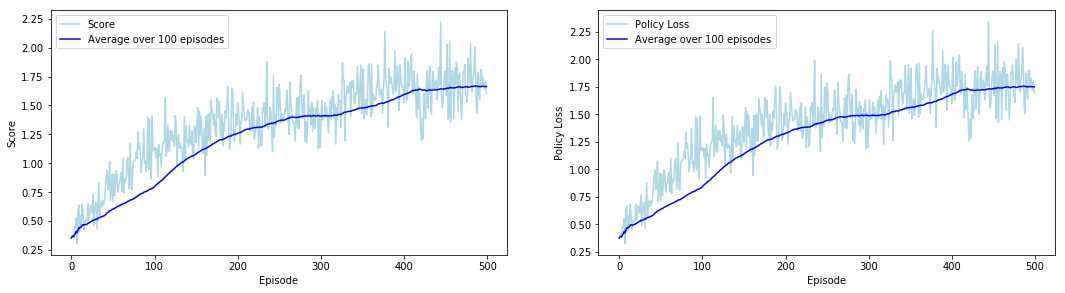

In [14]:
config = {}
config['env'] = env
config['episodes'] = 500
agent = Agent(config)
scores = env_utils.run(agent)

# plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4.5))
env_utils.plot_episodes(scores, 'Score', axis=ax1)
env_utils.plot_episodes(agent.policy_loss, 'Policy Loss', axis=ax2)

# save checkpoint
torch.save(agent.policy.state_dict(), 'checkpoints/REINFORCE-1.pth')

In [8]:
config = {}
config['env'] = env
config['train_mode'] = False
agent = Agent(config)
checkpoint = torch.load('checkpoints/REINFORCE-1.pth')
agent.policy.load_state_dict(checkpoint)
env_utils.run(agent)

<img src="img/REINFORCE-1.min.gif" style="padding-left: 10px" align="right"/>

Updates appear to be very noisy, and the average reward is very low even after training for 500 episodes. When I watch the agent, it's clear that agent is barely doing better than taking random actions.

### 8. REINFORCE Improvements

What are the main problems of REINFORCE? There are three issues:

1. The update process is very inefficient! We run the policy once, update once, and then throw away the trajectory.

2. The gradient estimate $\hat{g}$ is very noisy. By chance the collected trajectory may not be representative of the policy.

3. There is no clear credit assignment. A trajectory may contain many good/bad actions and whether these actions are reinforced depends only on the final total output.

In [22]:
class Agent():
    
    def __init__(self, config):
        self.config = config
        self.gamma = 0.99
        self.beta = 0.01 # entropy regularization parameter
        self.beta_decay = 0.995
        self.policy = Network(state_size, action_size, [64, 64])
        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4)
        self.storage = []
        self.policy_loss = []

    def act(self, states):
        prediction = self.policy(torch.from_numpy(states).float())
        dist = prediction['dist']

        actions = dist.mean
        if config.get('train_mode', True):
            actions = dist.sample()
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()

        return {'log_probs': log_probs, 'actions': actions, 'entropy': entropy}
    
    def step(self, states, actions_info, rewards, next_states, dones):
        actions, log_probs, entropy = itemgetter('actions', 'log_probs', 'entropy')(actions_info)
        self.storage.append((log_probs, entropy, rewards)) # added entropy term
        if np.any(dones):
            self.learn()

    def learn(self):
        log_probs, entropy, rewards = zip(*self.storage)
        log_probs = torch.stack(log_probs)
        entropy = torch.stack(entropy)

        """ Clear Credit Assignment: Discounted Future Rewards
        Note: arr[::-1] is just syntax to reverse an array.
        Calculating the discounted future reward is easier starting at the end.
        """
        accumulate_fn = lambda acc,r: r+self.gamma*np.asarray(acc)
        G = np.array(list(accumulate(rewards[::-1], accumulate_fn)))[::-1]
        
        """ Less Noisy: Normalize Rewards
        Batch normalization improves the speed, performance, and stability of a network.
        https://en.wikipedia.org/wiki/Batch_normalization

        Before normalizing, rewards were all positive for the Reacher environment.
        The normalized distribution, with μ = 0, produces both positive and negative rewards.
        Perhaps lack of negative rewards made it difficult to decrease bad action probabilities.
        """
        G = (G - np.mean(G))/np.std(G)
        G = torch.from_numpy(G.copy()).float().unsqueeze(2)

        """ Entropy Regularization to Encourage Exploration
        On-policy Reinforcement Learning with Entropy Regularization
        https://arxiv.org/abs/1912.01557
        """
        policy_loss = torch.mean(-log_probs * G - self.beta * entropy)
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        self.beta *= self.beta_decay
        self.policy_loss.append(policy_loss.detach().numpy())
        self.storage = []

Episode: 500 of 500 Score:   9.09 Time:  0:28:44                               


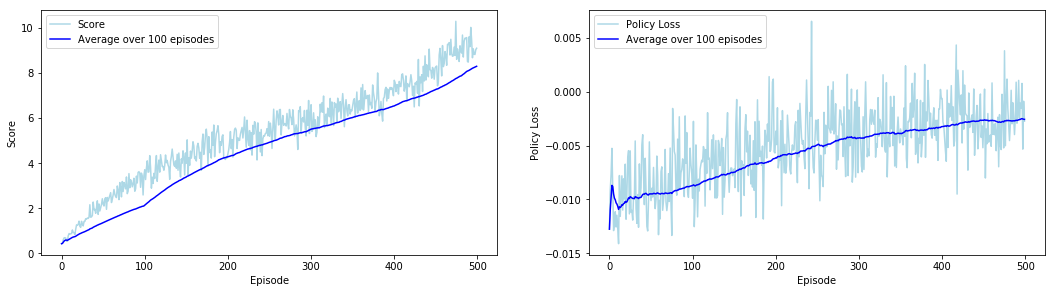

In [16]:
config = {}
config['env'] = env
config['episodes'] = 500
agent = Agent(config)
scores = env_utils.run(agent)

# plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4.5))
env_utils.plot_episodes(scores, 'Score', axis=ax1)
env_utils.plot_episodes(agent.policy_loss, 'Policy Loss', axis=ax2)

# save checkpoint
torch.save(agent.policy.state_dict(), 'checkpoints/REINFORCE-2.pth')

In [112]:
config = {}
config['env'] = env
config['train_mode'] = False
agent = Agent(config)
checkpoint = torch.load('checkpoints/REINFORCE-2.pth')
agent.policy.load_state_dict(checkpoint)
env_utils.run(agent)

<img src="img/REINFORCE-2.min.gif" style="padding-left: 10px;" align="right"/>

The agent learned some strategies!  It's doing a bit better than the first iteration of REINFORCE, but it's taking a long time to train, and I can still see long ways to go before they agent performs optimially.

### 9. Proximal Policy Optimization (PPO)

The updates to REINFORCE improved learning, but the agent is still taking a long time to learn the environment.  Recall one issue with REINFORCE is the update process is very inefficient! We run the policy once, update once, and then throw away the trajectory.

To tackle this issue, I implement the [PPO algorithm](https://arxiv.org/abs/1707.06347).

> We propose a new family of policy gradient methods for reinforcement learning, which alternate between sampling data through interaction with the environment, and optimizing a "surrogate" objective function using stochastic gradient ascent. Whereas standard policy gradient methods perform one gradient update per data sample, we propose a novel objective function that enables multiple epochs of minibatch updates. The new methods, which we call proximal policy optimization (PPO), have some of the benefits of trust region policy optimization (TRPO), but they are much simpler to implement, more general, and have better sample complexity (empirically). Our experiments test PPO on a collection of benchmark tasks, including simulated robotic locomotion and Atari game playing, and we show that PPO outperforms other online policy gradient methods, and overall strikes a favorable balance between sample complexity, simplicity, and wall-time.


The PPO algorithm is summarized below.

1. First, collect some trajectories based on some policy $\pi_{\theta}$, and initialize theta prime $\theta'=\theta$
2. Next, compute the gradient of the clipped surrogate function using the trajectories
3. Update $\theta'$ using gradient ascent $\theta'\leftarrow\theta' +\alpha \nabla_{\theta'}L_{\rm sur}^{\rm clip}(\theta', \theta)$
4. Then we repeat step 2-3 without generating new trajectories. Typically, step 2-3 are only repeated a few times
5. Set $\theta=\theta'$, go back to step 1, repeat.

The clipped surrogate function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

In [19]:
class Agent():
    
    def __init__(self, config):
        self.config = config
        self.gamma = 0.99
        self.beta = 0.01
        self.beta_decay = 0.995
        self.epsilon = 0.1 # parameter used for clipping
        self.sgd_epoch = 8 # number of times to use the trajectories
        self.policy = Network(state_size, action_size, [64, 64])
        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4)
        self.storage = []
        self.policy_loss = []

    def act(self, states):
        prediction = self.policy(torch.from_numpy(states).float())
        dist = prediction['dist']

        actions = dist.mean
        if config.get('train_mode', True):
            actions = dist.sample()
        log_probs = dist.log_prob(actions)

        return {'log_probs': log_probs, 'actions': actions}
    
    def step(self, states, actions_info, rewards, next_states, dones):
        log_probs, actions = itemgetter('log_probs', 'actions')(actions_info)
        self.storage.append((states, actions, log_probs, rewards))
        if np.any(dones):
            self.learn()

    def learn(self):
        states, actions, log_probs, rewards = zip(*self.storage)
        states = torch.from_numpy(np.asarray(states)).float()
        actions = torch.stack(actions)
        # NOTE: detach because we only update current gradient
        log_probs = torch.stack(log_probs).detach()
        
        accumulate_fn = lambda acc,r: r+self.gamma*np.asarray(acc)
        G = np.array(list(accumulate(rewards[::-1], accumulate_fn)))[::-1]
        G = (G - np.mean(G))/(np.std(G) + 1.0e-10)
        G = torch.from_numpy(G.copy()).float().unsqueeze(2)

        tmp_loss = []
        for e in range(self.sgd_epoch):

            prediction = self.policy(states)
            dist = prediction['dist']

            """ Calculate the Ratio
            Although the PPO algoritm indicates the use of a ratio, here I use log probabilities.
            The quotient rule for logarithms:  𝑙𝑜𝑔_b(𝑛/𝑚) = 𝑙𝑜𝑔_𝑏(𝑛) − 𝑙𝑜𝑔_𝑏(𝑚)
            Therefore: 𝑒^(log_e(𝜋𝜃′) − log_e(𝜋𝜃)) = 𝜋𝜃′/𝜋𝜃
            """
            new_log_probs = dist.log_prob(actions)
            ratio = (new_log_probs - log_probs).exp()

            """ The clip function is implemented in pytorch as
            torch.clamp(ratio, 1-epsilon, 1+epsilon)
            https://pytorch.org/docs/stable/torch.html#torch.clamp
            """
            obj = ratio * G
            obj_clipped = ratio.clamp(1.0 - self.epsilon, 1.0 + self.epsilon) * G

            L = -torch.min(obj, obj_clipped).mean() - \
                self.beta * dist.entropy().mean()

            self.optimizer.zero_grad()
            L.backward()
            self.optimizer.step()
            tmp_loss.append(L.detach().numpy())

        self.beta *= self.beta_decay
        self.policy_loss.append(np.mean(tmp_loss))
        self.storage = []

Episode: 500 of 500 Score:   19.5 Time:  0:30:56                               


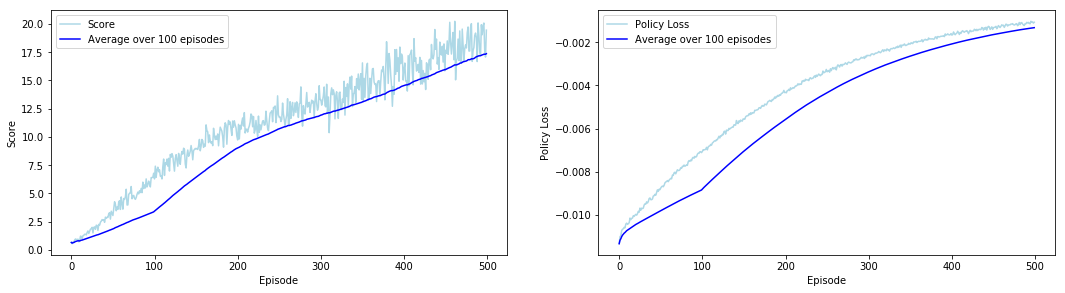

In [20]:
config = {}
config['env'] = env
config['episodes'] = 500
agent = Agent(config)
scores = env_utils.run(agent)

# plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4.5))
env_utils.plot_episodes(scores, 'Score', axis=ax1)
env_utils.plot_episodes(agent.policy_loss, 'Policy Loss', axis=ax2)

# save checkpoint
torch.save(agent.policy.state_dict(), 'checkpoints/PPO-1.pth')

In [10]:
config = {}
config['env'] = env
config['train_mode'] = False
agent = Agent(config)
checkpoint = torch.load('checkpoints/PPO-1.pth')
agent.policy.load_state_dict(checkpoint)
env_utils.run(agent)

[19.34199956767261]

<img src="img/PPO-1.min.gif" style="padding-left:10px;" align="right" />

Wow! PPO really improved learning efficiency.  If left to train for a while longer, the agent could probabably solve the Reacher environment, but 500 episodes should be plenty of experience to solve.

### Baseline with Actor-Critic


<img src="img/baseline.png" align="right" width="500">

One issue with policy gradient methods is with high variance due to Monte-Carlo estimations.  Even though the same states and actions can occur in multiple trajectories, the end result of the trajectory can vary widely, giving rise to high variance in policy updates.

\begin{align}
G_a = R^a_{t+1} + R^a_{t+2} + R^a_{t+2} \dots R^a_{t+H} = -100 \\
G_b = R^b_{t+1} + R^b_{t+2} + R^b_{t+2} \dots R^b_{t+H} = +100 \\
G_c = R^c_{t+1} + R^c_{t+2} + R^c_{t+2} \dots R^c_{t+H} = +1000 \\
\end{align}

Introducing a baseline can significantly reduce the variance of policy updates.  From [Reinforcement Learning: An Introduction](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) by Richard S. Sutton and Andrew G. Barto


> ... an analogous baseline can significantly reduce the variance (and thus speed the learning) of gradient bandit algorithms ... POLICY GRADIENT METHODS vary with state. In some states all actions have high values and we need a high baseline to differentiate the higher valued actions from the less highly valued ones; in other states all actions will have low values and a low baseline is appropriate.


We can rewrite the REINFORCE algorithm to include an arbitraty baseline $b(s)$:

\begin{align}
\nabla_\theta U(\theta) \approx \hat{g} := \frac1m\sum_{i=1}^m\sum_{t=0}^H\nabla_\theta log\pi_\theta(a_t^{(i)}|s_t^{(i)}R(\tau^{(i)}) \\
\nabla J(\theta) \ \alpha \sum_s\mu(s) \sum_a(q_\pi(s,a) - b(s))\nabla(a|s,\theta) \\
\theta \leftarrow \theta + \alpha(G_t - b(S_t)) \frac{\nabla\pi(A_t|S_t,\theta_t)}{\pi(A_t|S_t,\theta_t)}
\end{align}

I introduce the baseline using an Actor-Critic method.  The "critic" learns to evaluate state-value function using the TD-estimates.  Using the critic we calculate the advantage function, $A(s,a) = r + \gamma V(s') - V(s)$, and then train the "actor" using this value which represents how good an action is over the baseline.

Additionally, to more efficiently learn the state-value function, I provide a mixture of n-step bootstrapping returns using a method called [GAE](https://arxiv.org/abs/1506.02438).  With n-step bootstrapping, reward signals propagate to prior states more quickly because we look at more than just the next state-value when estimating target values.

In [5]:
class SubNetwork(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        self.layers.extend([nn.Linear(i, o) for i, o in zip(hidden_layers[:-1], hidden_layers[1:])])
        self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x, action=None):
        for i, layer in enumerate(self.layers):
            x = F.elu(layer(x))
        return self.output(x)

class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        # "actor" network outputs the distribution of actions
        self.actor = SubNetwork(input_size, output_size, hidden_layers)
        # "critic" network estimates state-value function
        self.critic = SubNetwork(input_size, 1, hidden_layers)
        self.std = nn.Parameter(torch.zeros(output_size))

    def forward(self, state):
        values = self.critic(state)
        x = self.actor(state)
        mean = torch.tanh(x)
        dist = torch.distributions.Normal(mean, F.softplus(self.std))
        return {'dist': dist, 'values': values}
    
policy = Network(state_size, action_size, [64, 64])
summary(policy, (1, state_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,176
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 1]              65
        SubNetwork-4                 [-1, 1, 1]               0
            Linear-5                [-1, 1, 64]           2,176
            Linear-6                [-1, 1, 64]           4,160
            Linear-7                 [-1, 1, 4]             260
        SubNetwork-8                 [-1, 1, 4]               0
Total params: 12,997
Trainable params: 12,997
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [6]:
class Agent():
    
    def __init__(self, config):
        self.config = config
        self.gamma = 0.99
        self.tau=0.95 # parameter for GAE 0=TD, 1=Monte-Carlo
        self.beta = 0.01
        self.beta_decay = 0.995
        self.epsilon = 0.1
        self.sgd_epoch = 8
        self.network = Network(state_size, action_size, [64, 64])
        self.optimizer = optim.Adam(self.network.parameters(), lr=5e-4)
        self.storage = []
        self.value_loss = []
        self.policy_loss = []

    def act(self, states):
        prediction = self.network(torch.from_numpy(states).float())
        dist = prediction['dist']
        values = prediction['values']

        actions = dist.mean
        if config.get('train_mode', True):
            actions = dist.sample()
        log_probs = dist.log_prob(actions)

        return {'log_probs': log_probs, 'actions': actions, 'values': values}
    
    def step(self, states, actions_info, rewards, next_states, dones):
        log_probs, actions, values = itemgetter('log_probs', 'actions', 'values')(actions_info)

        self.storage.append((states, actions, rewards, next_states, dones, values, log_probs))
        if np.any(dones):
            self.learn()

    def learn(self):
        to_numpy = lambda x: x.detach().numpy()
        tensor = lambda x: torch.from_numpy(np.asarray(x)).float()

        states, actions, rewards, next_states, dones, values, log_probs = zip(*self.storage)
        rewards = torch.tensor(np.asarray(rewards)).float().unsqueeze(2)
        dones = torch.tensor(np.asarray(dones).astype(np.uint8)).float().unsqueeze(2)
        states = tensor(states)
        actions = torch.stack(actions)
        values = torch.stack(values)
        log_probs = torch.stack(log_probs).detach()

        """ Compute Returns and Advantages
        TD-Estimates are used in placed of Monte-Carlo returns.
        
        GAE:
        The parameter tau indicates how much to consider future TD-estimates.
        tau = 0 is the same as TD estimate
        tau = 1 is equivalent to the Monte-Carlo estimate         
        """
        advantages = []
        returns = []

        # If playing out a full episode, the value is 0 for terminal state
        # However, if training after n time steps, we grab one extra value for computing returns
        prediction_next = self.network(tensor(next_states[-1]))
        next_values = itemgetter('values')(prediction_next).unsqueeze(0)
        v = torch.cat([values, next_values])

        A = tensor(np.zeros((20, 1)))
        G = next_values # could initialize to 0 if only using full episodes
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.gamma * (1 - dones[t]) * G
            td_error = rewards[t] + self.gamma * v[t + 1] * (1 - dones[t]) - v[t]
            A = td_error + self.gamma * self.tau * (1 - dones[t]) * A
            advantages.insert(0, A.detach())
            returns.insert(0, G.detach())

        # Normalize advantages, same as with rewards.
        advantages = torch.stack(advantages)
        advantages = (advantages - advantages.mean()) / advantages.std()
        # Do not normalize returns to train value function using td-error.
        returns = torch.stack(returns)

        tmp_policy_loss = []
        tmp_value_loss = []
        for e in range(self.sgd_epoch):

            prediction = self.network(states)
            dist, values = itemgetter('dist', 'values')(prediction)
            new_log_probs = dist.log_prob(actions)

            ratio = (new_log_probs - log_probs).exp()

            # using advantages instead of Monte-Carlo returns
            obj = ratio * advantages
            obj_clipped = ratio.clamp(1.0 - self.epsilon, 1.0 + self.epsilon) * advantages

            policy_loss = -torch.min(obj, obj_clipped).mean() - \
                self.beta * dist.entropy().mean()
            
            # MSE loss for "critic"
            value_loss = 0.5 * (values - returns).pow(2).mean()

            self.optimizer.zero_grad()
            (policy_loss + value_loss).backward()
            self.optimizer.step()

            tmp_policy_loss.append(to_numpy(policy_loss))
            tmp_value_loss.append(to_numpy(value_loss))

        self.beta *= self.beta_decay
        self.storage = []

        self.policy_loss.append(np.mean(tmp_policy_loss))
        self.value_loss.append(np.mean(tmp_value_loss))

Episode: 500 of 500 Score:   38.5 Time:  0:54:53                               


Solved in 323 episodes!


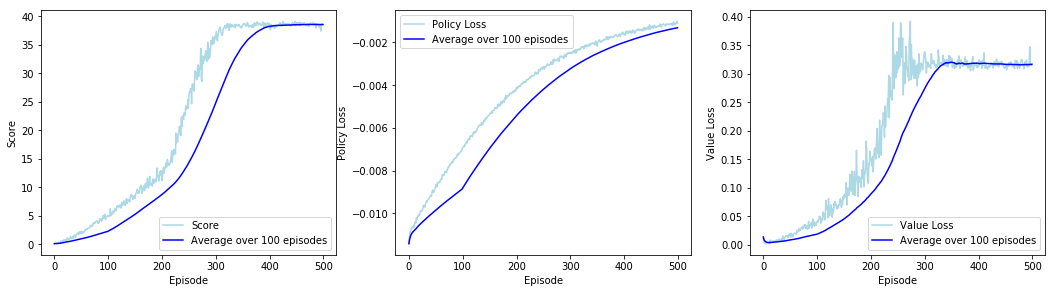

In [7]:
config = {}
config['env'] = env
config['episodes'] = 500
agent = Agent(config)
scores = env_utils.run(agent)

# plot results
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4.5))
env_utils.plot_episodes(scores, 'Score', axis=ax1)
env_utils.plot_episodes(agent.policy_loss, 'Policy Loss', axis=ax2)
env_utils.plot_episodes(agent.value_loss, 'Value Loss', axis=ax3)

# Get episode where agent first averaged over 30 for past 100 episodes
avg_scores = env_utils.get_rolling_avg(scores, n=100)
episode = np.argmax(np.asarray(avg_scores) > 30)
print("Solved in {} episodes!".format(episode))

# save checkpoint
torch.save(agent.network.state_dict(), 'checkpoints/PPO-2.pth')

In [9]:
config = {}
config['env'] = env
config['train_mode'] = False
agent = Agent(config)
checkpoint = torch.load('checkpoints/PPO-2.pth')
agent.network.load_state_dict(checkpoint)
env_utils.run(agent)

[38.85499913152307]

### Conclusion

<img src="img/PPO-2.min.gif" style="padding-left:10px;" align="right" />

The agent is finally able to solve the environment!  It's really satisfying to see the agent performance improve along the way.  Let's recap the changes.

* Started with the REINFORCE algorithm as a baseline.
* Introduced clear credit assignment with discounted future rewards.
* Normalized rewards to improve speed, performance, and stability of a network.
* Added entropy regularization to encourage initial exploration.
* PPO algorithm for more efficient use of experiences.
* Actor Critic and GAE to reduce variance in learning associated with Monte-Carlo methods.

### Improvement Ideas

* Currently, the agent completes the entire epsisode before training, so we could allow the agent to train after $n$ timesteps to allow the agent to start learning before the episode is over.
* With TD-estimates we might improve stability with target networks from [DQN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) or fixed networks with a soft update as in [D4PG](https://arxiv.org/abs/1509.02971).
* Even though there are 20 agents in this environment, which provides decorrelated experiences, would it help to introduce random sampling of the available experiences through mini batches?
* Compare results with additional algorithms capable of handling continous actions, including [D4PG](https://arxiv.org/abs/1509.02971) and [A3C](https://arxiv.org/abs/1602.01783).
* Try more combinations of parameters to find the best network and hyperparameters, as well as try many times to make sure that the performance is consistent.